In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import datetime
import seaborn as sns
from datetime import date
import sklearn
from sklearn.preprocessing import LabelEncoder
from datetime import date
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import train_test_split,GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, f1_score
import warnings
warnings.filterwarnings('ignore') #action='once')


In [19]:
df = pd.read_table('./processed/feature_engineering.csv', sep=',', index_col = 0)
df.head()

,institution,MDN,NotitieID,Typenotitie,Notitiedatum,annotated,ADM_lvl,ATT_lvl,BER_lvl,ENR_lvl,...,avg_domains,rolling_mean3,rolling_mean7,rolling_sum3,rolling_sum7,rolling_min3,rolling_min7,rolling_max3,rolling_max7,expanding_mean
67031,amc,138098,457333386,Zorgplan/VPK rapportage,2020-10-14,False,3.034180,NaN,NaN,1.566406,...,2.933268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
77391,amc,138098,456811920,Voortgangsverslag,2020-10-14,False,3.034180,NaN,NaN,1.410156,...,2.383789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.034180
66123,amc,138098,457532765,Voortgangsverslag,2020-10-15,False,2.912109,NaN,NaN,1.762695,...,2.337402,2.993490,NaN,8.980469,NaN,2.912109,NaN,3.034180,NaN,2.993490
77392,amc,138098,457533093,Zorgplan/VPK rapportage,2020-10-15,False,3.478516,NaN,NaN,NaN,...,3.683594,3.141602,NaN,9.424805,NaN,2.912109,NaN,3.478516,NaN,3.114746
79526,amc,138098,457617575,Zorgplan/VPK rapportage,2020-10-15,False,3.478516,NaN,NaN,NaN,...,3.704102,3.289714,NaN,9.869141,NaN,2.912109,NaN,3.478516,NaN,3.187500


## Modelling

### Trying to predict fro ADM_lvl variable

In [20]:
df = df.drop(['institution', 'Typenotitie', 'Notitiedatum', 'ATT_lvl', 'BER_lvl', 'ENR_lvl', 'ETN_lvl', 'FAC_lvl', 'INS_lvl', 'MBW_lvl', 'STM_lvl'], axis=1)
col = df.pop('ADM_lvl')
df.insert(0, col.name, col)
df = df.dropna()

In [21]:
# discretize variables by rounding continuous var into integers
labelenc = LabelEncoder()
df['ADM_lvl'] = df['ADM_lvl'].round(0)
df.iloc[:,0] = labelenc.fit_transform(df.iloc[:,0].values)

In [22]:
df.dtypes

ADM_lvl             int64
MDN                 int64
NotitieID           int64
annotated            bool
year                int64
month               int64
day                 int64
Days_count          int64
Dif                 int64
lag1_ADM            int64
lag2_ADM            int64
lag3_ADM            int64
avg_domains       float64
rolling_mean3     float64
rolling_mean7     float64
rolling_sum3      float64
rolling_sum7      float64
rolling_min3      float64
rolling_min7      float64
rolling_max3      float64
rolling_max7      float64
expanding_mean    float64
dtype: object

In [23]:
#80% of patients in train and 20% of patients in test.

train_inds, test_inds = next(GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 0).split(df, groups=df['MDN']))
train = df.iloc[train_inds]
test = df.iloc[test_inds]

In [24]:
#Now split the data into X and Y
X_train = train.iloc[:, 1:].values
Y_train = train.iloc[:, 0].values

X_test = test.iloc[:, 1:].values
Y_test = test.iloc[:, 0].values

In [25]:
print(X_train.shape)
print(Y_train.shape)

print(X_test.shape)
print(Y_test.shape)

(13904, 21)
(13904,)
(3695, 21)
(3695,)


In [26]:
#easier and faster for models to train we scale the data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

In [27]:
#now the models themselves:
def models(X_train, Y_train):
    
    #Logistic Regression
    from sklearn.linear_model import LogisticRegression
    log = LogisticRegression(random_state=0, multi_class='multinomial')
    log.fit(X_train, Y_train)
    
    #KNN
    from sklearn.neighbors import KNeighborsClassifier
    knn = KNeighborsClassifier(n_neighbors = 7, metric = 'minkowski', p=2)
    knn.fit(X_train, Y_train)
    
    #Gaussian Naive Bayes
    from sklearn.naive_bayes import GaussianNB
    gauss = GaussianNB()
    gauss.fit(X_train, Y_train)
    
    #Decision Tree
    from sklearn.tree import DecisionTreeClassifier
    tree = DecisionTreeClassifier(criterion = 'entropy', random_state=0)
    tree.fit(X_train, Y_train)
    
    #Random Forest
    from sklearn.ensemble import RandomForestClassifier
    forest = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state=0)
    forest.fit(X_train, Y_train)
    
    #Accuracy for each model
    print('Accuracy on training data for each model: \n')
    print('Log Reg: ', log.score(X_train, Y_train))
    print('KNN: ', knn.score(X_train, Y_train))
    print('Gauss Naive Bayes: ', gauss.score(X_train, Y_train))
    print('Decision Tree: ', tree.score(X_train, Y_train))
    print('Random Forest: ', forest.score(X_train, Y_train))
    
    
    return log, knn, gauss, tree, forest

### Training set

In [11]:
#train all models:
model = models(X_train, Y_train)

#Retrieve F1-macro scores for training per model
print('\n F1-macro score per model \n')
print('Log Reg: ' + str (f1_score(Y_train, model[0].predict(X_train), average='macro')))
print('KNN: ' + str (f1_score(Y_train, model[1].predict(X_train), average='macro')))
print('Gauss Naive Bayes: ' + str (f1_score(Y_train, model[2].predict(X_train), average='macro')))
print('Decision Tree: ' + str (f1_score(Y_train, model[3].predict(X_train), average='macro')))
print('Random Forest: ' + str (f1_score(Y_train, model[4].predict(X_train), average='macro')))

Accuracy on training data for each model: 

Log Reg:  0.7030350978135789
KNN:  0.7696346375143843
Gauss Naive Bayes:  0.6237054085155351
Decision Tree:  1.0
Random Forest:  0.9974827387802071

 F1-macro score per model 

Log Reg: 0.701926459758144
KNN: 0.7661148798698554
Gauss Naive Bayes: 0.6161136394974771
Decision Tree: 1.0
Random Forest: 0.9971930848313704


### Test set

In [12]:
#predict and metrics for testset

print('Conf matrix and F1-macro score per model: \n')
print('Log Reg: \n', confusion_matrix(Y_test, model[0].predict(X_test)), f1_score(Y_test, model[0].predict(X_test), average='macro'))
print('\n KNN: \n', confusion_matrix(Y_test, model[1].predict(X_test)),f1_score(Y_test, model[1].predict(X_test), average='macro'))
print('\n Gauss Naive Bayes: \n', confusion_matrix(Y_test, model[2].predict(X_test)),f1_score(Y_test, model[2].predict(X_test), average='macro'))
print('\n Decision Tree: \n', confusion_matrix(Y_test, model[3].predict(X_test)),f1_score(Y_test, model[3].predict(X_test), average='macro'))
print('\n Random Forest: \n', confusion_matrix(Y_test, model[4].predict(X_test)),f1_score(Y_test, model[4].predict(X_test), average='macro'))

Conf matrix and F1-macro score per model: 

Log Reg: 
 [[559 189   0   0   0]
 [ 75 854 155   3   3]
 [  2 252 440  71   5]
 [  0  32 184 220  57]
 [  0   1  12 123 458]] 0.6762967516989218

 KNN: 
 [[553 187   8   0   0]
 [ 96 869 121   2   2]
 [ 10 279 444  33   4]
 [  0  52 189 191  61]
 [  0   9  44 149 392]] 0.6466536099487044

 Gauss Naive Bayes: 
 [[640 101   7   0   0]
 [165 739 149  31   6]
 [ 49 273 322  94  32]
 [  3  54 130 215  91]
 [  1   3  17 103 470]] 0.6319947106094473

 Decision Tree: 
 [[ 688   57    3    0    0]
 [   9 1041   38    0    2]
 [   2   56  693   18    1]
 [   0    5  109  366   13]
 [   1    1   13  154  425]] 0.8518508879477583

 Random Forest: 
 [[ 693   51    4    0    0]
 [  11 1045   25    8    1]
 [   2   87  668   12    1]
 [   1   10  106  364   12]
 [   0    0   17  157  420]] 0.8458947042582283


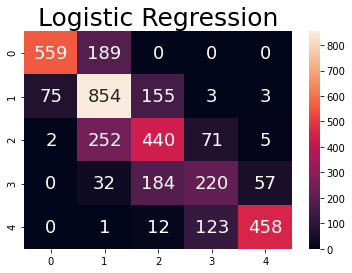

In [13]:
ax = plt.axes()
sns.heatmap(confusion_matrix(Y_test, model[0].predict(X_test)),fmt="d", annot=True, annot_kws={"size": 18}, ax=ax)

ax.set_title('Logistic Regression', fontsize=25)
plt.savefig("./figures/confusion_matrix_LR.png",dpi=300)
plt.show()


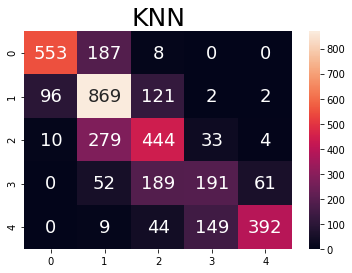

In [14]:
ax1 = plt.axes()
sns.heatmap(confusion_matrix(Y_test, model[1].predict(X_test)),fmt="d", annot=True, annot_kws={"size": 18}, ax=ax1)

ax1.set_title('KNN', fontsize=25)
plt.savefig("./figures/confusion_matrix_KNN.png",dpi=300)
plt.show()

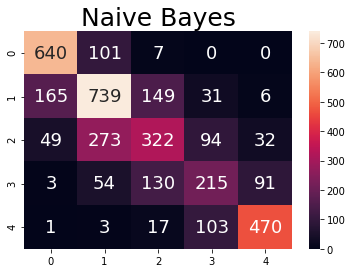

In [15]:
ax2 = plt.axes()
sns.heatmap(confusion_matrix(Y_test, model[2].predict(X_test)),fmt="d", annot=True, annot_kws={"size": 18}, ax=ax2)

ax2.set_title('Naive Bayes', fontsize=25)
plt.savefig("./figures/confusion_matrix_NB.png",dpi=300)
plt.show()

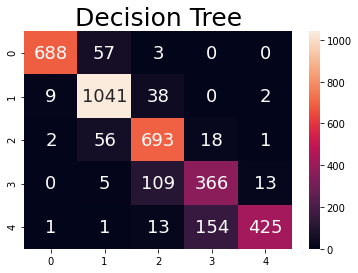

In [16]:
ax3 = plt.axes()
sns.heatmap(confusion_matrix(Y_test, model[3].predict(X_test)),fmt="d", annot=True, annot_kws={"size": 18}, ax=ax3)

ax3.set_title('Decision Tree', fontsize=25)
plt.savefig("./figures/confusion_matrix_DT.png",dpi=300)
plt.show()

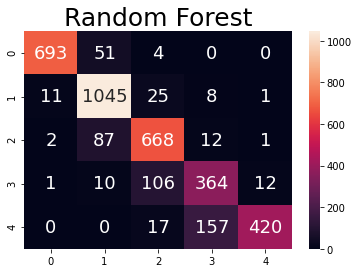

In [17]:
ax4 = plt.axes()
sns.heatmap(confusion_matrix(Y_test, model[4].predict(X_test)),fmt="d", annot=True, annot_kws={"size": 18}, ax=ax4)

ax4.set_title('Random Forest', fontsize=25)
plt.savefig("./figures/confusion_matrix_RF.png",dpi=300)
plt.show()